In [ ]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566164 sha256=d8a97d68ae92829f7e0ede9652eb669e401e7abd85efa9cef9689acb0f15454c
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
#Model with feature visualization
from torch import nn
from torchvision import models
class Model3(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model3, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [ ]:
import cv2
from io import BytesIO
import numpy as np
import face_recognition
import matplotlib.pyplot as plt

def extract_faces_from_video(video_path):
    video_capture = cv2.VideoCapture(video_path)
    face_frames = []

    while True:
        ret, frame = video_capture.read()  # Read a frame from the video stream

        if not ret:
            break  # Break the loop if no more frames are available

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(frame)

        if face_locations:
            for face in face_locations:
                top, right, bottom, left = face
                face_frame = frame[top:bottom, left:right]
                face_frame = cv2.resize(face_frame, (128, 128))  # Resize for model input
                face_frames.append(face_frame)

    video_capture.release()
    return face_frames


In [ ]:
import random

def extract_faces_from_video(video_path, num_frames=30):
    video_capture = cv2.VideoCapture(video_path)

    # Get total number of frames in the video
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))


    # Randomly select a starting frame
    start_frame = 0 if num_frames > total_frames else random.randint(0, total_frames - num_frames)
    face_frames = []

    video_capture.set(cv2.CAP_PROP_POS_FRAMES, start_frame)  # Move to the starting frame

    batch_size = 4
    frames_buffer = []

    for _ in range(num_frames):
        ret, frame = video_capture.read()  # Read a frame from the video stream

        if not ret:
            break  # Break the loop if no more frames are available

        frames_buffer.append(frame)

        # Process in batches of 4 frames
        if len(frames_buffer) == batch_size:
            # Detect faces in the current batch of frames
            faces_batch = []
            for frame in frames_buffer:
                face_locations = face_recognition.face_locations(frame)
                for face in face_locations:
                    top, right, bottom, left = face
                    face_frame = frame[top:bottom, left:right]
                    face_frame = cv2.resize(face_frame, (128, 128))  # Resize for model input
                    faces_batch.append(face_frame)
            face_frames.extend(faces_batch)
            frames_buffer = []  # Clear the buffer for the next batch

    # Process any remaining frames in the buffer
    if frames_buffer:
        faces_batch = []
        for frame in frames_buffer:
            face_locations = face_recognition.face_locations(frame)
            for face in face_locations:
                top, right, bottom, left = face
                face_frame = frame[top:bottom, left:right]
                face_frame = cv2.resize(face_frame, (128, 128))  # Resize for model input
                faces_batch.append(face_frame)
        face_frames.extend(faces_batch)

    video_capture.release()
    return face_frames


In [ ]:
video_path = '/content/drive/MyDrive/DeepFake/Celeb_real_face_only/id0_0000.mp4'
face_frames = extract_faces_from_video(video_path,num_frames=60)

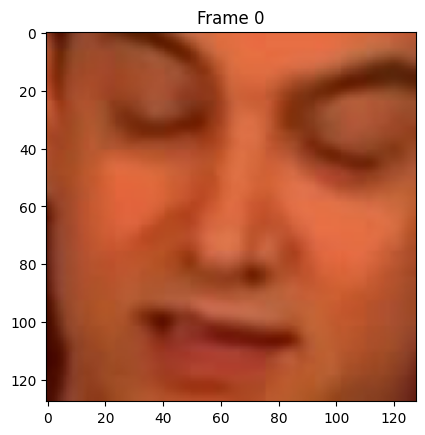

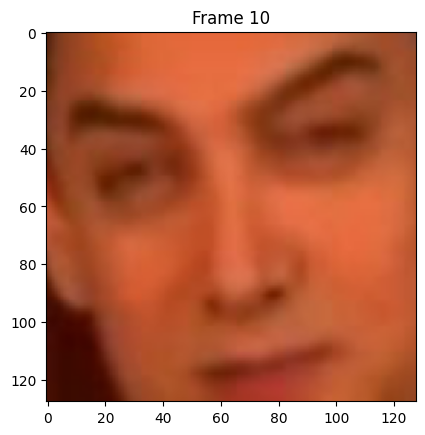

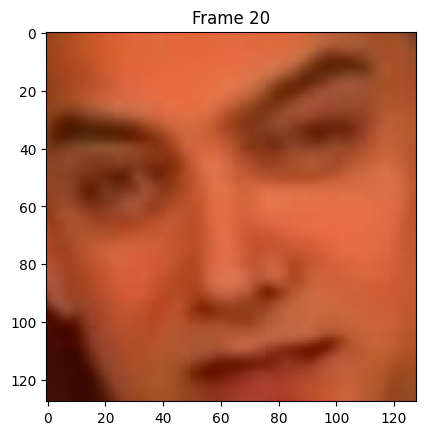

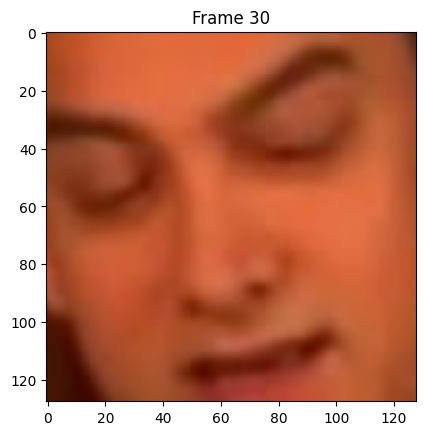

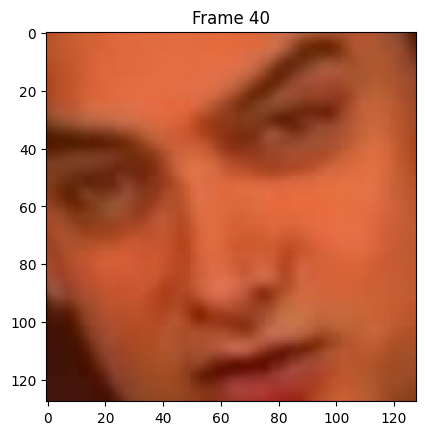

In [ ]:
for i, frame in enumerate(face_frames):
  if i % 10 == 0:  # Process every 10th frame
    # Convert the frame to RGB (OpenCV uses BGR)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the frame using Matplotlib
    plt.imshow(frame_rgb)
    plt.title(f"Frame {i}")
    plt.show()

    if i > 50:  # Limit the number of frames to process
      break

In [ ]:
from torchvision import transforms

def preprocess_face_frames(face_frames, device='cpu'):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    preprocessed_frames = torch.stack([preprocess(frame) for frame in face_frames]).to(device)

    # Add batch dimension and sequence length dimension
    preprocessed_frames = preprocessed_frames.unsqueeze(0)  # Shape: (1, seq_length, c, h, w)

    return preprocessed_frames


In [ ]:
def predict(model, preprocessed_input):
    with torch.no_grad():  # Disable gradient computation for inference
        fmap, output = model(preprocessed_input)
    return fmap, output




In [ ]:
def postprocess_output(output):
    #classification task
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities


In [ ]:
import torch

def load_model(model_path, num_classes, device='cpu'):
    model = Model3(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    return model

def predict_face_video(model_path, face_frames, num_classes, device='cpu'):
    model = load_model(model_path, num_classes, device)

    preprocessed_input = preprocess_face_frames(face_frames, device)

    fmap, output = predict(model, preprocessed_input)

    predicted_class, probabilities = postprocess_output(output)

    return predicted_class, probabilities, fmap


In [ ]:
def classify_video(video_path, model_path, num_classes, device='cpu'):
    # Step 1: Extract faces from the video
    face_frames = extract_faces_from_video(video_path)

    # Step 2: Predict using the model
    predicted_class, probabilities, fmap = predict_face_video(model_path, face_frames, num_classes, device)

    return predicted_class, probabilities

# Example usage
video_path = '/content/drive/MyDrive/DeepFake/Celeb_real_face_only/id0_0000.mp4'
model_path = '/content/drive/MyDrive/model3.pt'
num_classes = 2  # Number of classes in your model
device = 'cuda'  # Or 'cpu' if not using GPU

predicted_class, probabilities = classify_video(video_path, model_path, num_classes, device)
print(f"Predicted class: {predicted_class}")
print(f"Probabilities: {probabilities}")


<ipython-input-45-8daae9d46cdd>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Predicted class: tensor([1], device='cuda:0')
Probabilities: tensor([[0.0666, 0.9334]], device='cuda:0')


In [ ]:
video_path = '/content/drive/MyDrive/DeepFake/Celeb-real/id0_0008.mp4'
model_path = '/content/drive/MyDrive/model3.pt'
num_classes = 2  # Number of classes in your model
device = 'cuda'  # Or 'cpu' if not using GPU

predicted_class, probabilities = classify_video(video_path, model_path, num_classes, device)
print(f"Predicted class: {predicted_class}")
print(f"Probabilities: {probabilities}")

<ipython-input-45-8daae9d46cdd>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Predicted class: tensor([1], device='cuda:0')
Probabilities: tensor([[0.0267, 0.9733]], device='cuda:0')
